
#  オペレーティングシステム 演習 03
#  スレッド


名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name: 金井優希
 * 学生証番号 Student ID: 03-249217


# 1. スレッド関連コマンド

## 1-1. ps auxmww
* ps は現存するプロセスを表示するコマンド
* mをつけると各プロセス内のスレッドも表示される

* 以下によりシステムのすべてのプロセスのすべてのスレッドが表示される
* 出力が一杯になりすぎたり, そのせいでエラーになったら一旦ファイルへ出力し, そのファイルを開けば良い
* 例えば
```
ps auxmww > ps.txt
```

In [2]:
ps auxmww > ps.txt


# 2. スレッド
## 2-1. C (POSIX Threads または Pthreads)
* PthreadはUnix共通のスレッドAPI
* 基本
  * pthread_create でスレッドを作り, 実行
  * pthread_join でスレッドの終了を待つ
  * pthread_exit で呼び出したスレッドを終了させる
  * pthread_self は呼び出したスレッドのthread IDを返す

* 以下はともかくスレッドを作ってjoinするだけの例

In [1]:
%%writefile thread_create.c
#include <err.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <pthread.h>

/* スレッドの開始関数 */
void * f(void * arg) {
  pthread_t thread_id = pthread_self();
  int slp_n = 5;
  for (int i = 0; i < slp_n; i++) {
    printf("child[%lu]: (%d/%d)\n",
           thread_id, i, slp_n);
    fflush(stdout);
    usleep(100 * 1000);
  }
  return arg + 1;
}

int main() {
  pthread_t my_thread_id = pthread_self();
  pthread_t child_thread_id;
  /* スレッドを作る */
  if (pthread_create(&child_thread_id, 0, f, 0)) {
    err(1, "pthread_create");
  }
  int slp_n = 5;
  for (int i = 0; i < slp_n; i++) {
    printf("parent[%lu]: (%d/%d)\n", my_thread_id, i, slp_n);
    fflush(stdout);
    usleep(100 * 1000);
  }
  /* 終了待ち */
  void * ret = 0;
  if (pthread_join(child_thread_id, &ret)) {
    err(1, "pthread_join");
  }
  printf("child thread returned %p\n", ret);
  return 0;
}

Writing thread_create.c


In [2]:
gcc -Wall thread_create.c -o thread_create -lpthread

In [3]:
./thread_create

parent[140234227898176]: (0/5)
child[140234227893824]: (0/5)
parent[140234227898176]: (1/5)
child[140234227893824]: (1/5)
parent[140234227898176]: (2/5)
child[140234227893824]: (2/5)
parent[140234227898176]: (3/5)
child[140234227893824]: (3/5)
parent[140234227898176]: (4/5)
child[140234227893824]: (4/5)
child thread returned 0x1


## 2-2. Python (threadingモジュール)
* 基本
  * th = threading.Thread(...) でスレッドオブジェクトを作り, th.start() で実行
  * th.join() でスレッドの終了を待つ
    * ただし pthread のAPIと違って子スレッドの終了ステータスは得られない(あまり必然性のない制限)
  * threading.current_thread() は呼び出したスレッドのスレッドオブジェクトを返す
    * th.native_id で スレッド th の OSレベルのthread IDが得られるようである

In [4]:
%%writefile thread_create.py
import threading
import time

def f(arg):
    th = threading.current_thread()
    slp_n = 5
    for i in range(slp_n):
        print(f"child[{th.native_id}]: ({i}/{slp_n})", flush=True)
    time.sleep(0.1)

def main():
    my_th = threading.current_thread()
    child_th = threading.Thread(target=f, args=(0,))
    child_th.start()
    slp_n = 5
    for i in range(slp_n):
        print(f"parent[{my_th.native_id}]: ({i}/{slp_n})", flush=True)
        time.sleep(0.1)
    child_th.join()

main()

Writing thread_create.py


In [5]:
python thread_create.py

Command 'python' not found, did you mean:
  command 'python3' from deb python3
  command 'python' from deb python-is-python3


: 127


# 3. スレッドに引数を渡す
* 普通は, スレッドを複数作ったらそれぞれに違う仕事をやらせたい
* そのためにスレッドが実行する関数(開始関数)に異なる引数を渡すのが普通だが, pthread のAPIでは開始関数がvoid* (ポインタ)型の引数1つしか取れないという制限がある (Pythonでは任意個の引数をタプルとして渡せる)
```
void * f(void *) { ... }
```
* そのため通常, 構造体を作りそれへのポインタを引数として渡す
```
typedef struct { int xxx; double yyy; ... } thread_arg_t;
```
* 開始関数の方では受け取った void* 型を構造体へのポインタ変数に代入し, そこから値を取り出すのが常套手段
```
void * f(void * arg_) {
  thread_arg_t * arg = arg_;
  arg->xxx, arg->yyy, ...
}
```
* 開始関数はvoid* を受け取るが, それに構造体のポインタを渡しても問題はない

## 3-1. C

In [6]:
%%writefile thread_create_arg.c
#include <assert.h>
#include <err.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <pthread.h>

/* 開始関数に渡したい情報(構造体) */
typedef struct {
  long slp_usec;
  long slp_n;
  long id;                       /* 0,1,2,.. */
  pthread_t th_id;
} thread_arg_t;

/* 開始関数 構造体へのポインタを (void *型で)受け取る */
void * f(void * arg_) {
  thread_arg_t * arg = arg_;
  /* 本当に受け取りたい引数を構造体から受け取る */
  long slp_usec = arg->slp_usec;
  long slp_n = arg->slp_n;
  long id = arg->id;
  pthread_t thread_id = pthread_self();
  for (int i = 0; i < slp_n; i++) {
    printf("child[%ld/%lu] (%d/%ld): sleep %ld usec\n",
           id, thread_id, i, slp_n, slp_usec);
    fflush(stdout);
    usleep(slp_usec);
  }
  return 0;
}

int main(int argc, char ** argv) {
  int nthreads = (argc > 1 ? atoi(argv[1]) : 3);
  thread_arg_t args[nthreads];
  /* 指定された数のスレッドを作る */
  for (int i = 0; i < nthreads; i++) {
    args[i].slp_n = i + 2;
    args[i].slp_usec = 1000 * 1000 / args[i].slp_n;
    args[i].id = i;
    if (pthread_create(&args[i].th_id, 0, f, &args[i])) {
      err(1, "pthread_create");
    }
  }
  /* 終了待ち */
  for (int i = 0; i < nthreads; i++) {
    void * ret;
    if (pthread_join(args[i].th_id, &ret)) {
      err(1, "pthread_join");
    }
    assert(ret == 0);
    printf("child thread %d returned (%p)\n", i, ret);
  }  
  return 0;
}

Writing thread_create_arg.c


In [7]:
gcc -Wall -o thread_create_arg thread_create_arg.c -lpthread

In [8]:
./thread_create_arg

child[0/139927573435968] (0/2): sleep 500000 usec
child[1/139927565043264] (0/3): sleep 333333 usec
child[2/139927556650560] (0/4): sleep 250000 usec
child[2/139927556650560] (1/4): sleep 250000 usec
child[1/139927565043264] (1/3): sleep 333333 usec
child[0/139927573435968] (1/2): sleep 500000 usec
child[2/139927556650560] (2/4): sleep 250000 usec
child[1/139927565043264] (2/3): sleep 333333 usec
child[2/139927556650560] (3/4): sleep 250000 usec
child thread 0 returned ((nil))
child thread 1 returned ((nil))
child thread 2 returned ((nil))


## 3-2. Python

In [9]:
%%writefile thread_create_arg.py
import sys
import threading
import time

def f(slp_n, slp_usec, idx):
    th = threading.current_thread()
    for i in range(slp_n):
        print(f"child[{idx}/{th.native_id}] ({i}/{slp_n}): sleep {slp_usec} usec",
               flush=True)
        time.sleep(slp_usec * 1e-6)

def main():
    nthreads = int(sys.argv[1]) if 1 < len(sys.argv) else 3
    # 指定された数のスレッドを作る
    threads = []
    for i in range(nthreads):
        slp_n = i + 2
        th = threading.Thread(target=f, args=(slp_n, 1e6 / slp_n, i))
        th.start()
        threads.append(th)
    # 終了待ち
    for th in threads:
        th.join()

main()

Writing thread_create_arg.py


In [10]:
python3 thread_create_arg.py

child[0/2229442] (0/2): sleep 500000.0 usec
child[1/2229443] (0/3): sleep 333333.3333333333 usec
child[2/2229444] (0/4): sleep 250000.0 usec
child[2/2229444] (1/4): sleep 250000.0 usec
child[1/2229443] (1/3): sleep 333333.3333333333 usec
child[0/2229442] (1/2): sleep 500000.0 usec
child[2/2229444] (2/4): sleep 250000.0 usec
child[1/2229443] (2/3): sleep 333333.3333333333 usec
child[2/2229444] (3/4): sleep 250000.0 usec



# 4. スレッド vs プロセスの違いを理解する
* 違いは色々あるものの, どちらもCPU (正確には仮想コア)を複数使うための道具であることも確か
* 端的にその挙動の違いは
  * 「1プロセス間の複数スレッドはメモリ(変数)を共有している」
  * 「複数プロセス間ではメモリは共有されない」
という違いがある

* 特にfork()は「コピー」を作っているのであって親プロセスと子プロセスでデータ(変数)が共有されているわけではないことに注意

* 以下が違いを示す例
* 表示される結果を予想してから実行し, 何が起きているのかを理解せよ


* プロセス(fork)を使う例

* C

In [11]:
%%writefile thread_vs_fork_fork.c
#include <err.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <sys/types.h>
#include <sys/wait.h>

int x = 0;

/* スレッドの開始関数 */
void * f(void * arg) {
  x += 321;
  return 0;
}

int main() {
  x = 123;
  
  pid_t pid = fork();
  if (pid == -1) {
    err(1, "fork");
  } else if (pid == 0) {          /* child */
    f(0);
    return 0;
  } else {
    int ws;
    pid_t cid = waitpid(pid, &ws, 0);
    if (cid == -1) err(1, "waitpid");
    if (WIFEXITED(ws)) {
      printf("exited, status=%d\n", WEXITSTATUS(ws));
      fflush(stdout);
    } else if (WIFSIGNALED(ws)) {
      printf("killed by signal %d\n", WTERMSIG(ws));
      fflush(stdout);
    }
    printf("after the child finished, x = %d\n", x);
  }
  return 0;
}

Writing thread_vs_fork_fork.c


In [12]:
gcc -Wall -o thread_vs_fork_fork thread_vs_fork_fork.c

In [13]:
./thread_vs_fork_fork

exited, status=0
after the child finished, x = 123


* Python

In [14]:
%%writefile thread_vs_fork_fork.py
import os

x = 0

def f():
    global x
    x += 321

def main():
    global x
    x = 123
  
    pid = os.fork()
    if pid == 0:
        f()
    else:
        cid, ws = os.waitpid(pid, 0)
        if os.WIFEXITED(ws):
            print(f"exited, status={os.WEXITSTATUS(ws)}", flush=True)
        elif os.WIFSIGNALED(ws):
            print(f"killed by signal {os.WTERMSIG(ws)}", flush=True)
        print(f"after the child finished, x = {x}")

main()

Writing thread_vs_fork_fork.py


In [15]:
python3 thread_vs_fork_fork.py

exited, status=0
after the child finished, x = 123


* スレッド(pthread_create)を使う例

* C

In [16]:
%%writefile thread_vs_fork_thread.c
#include <err.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <pthread.h>

int x = 0;

/* スレッドの開始関数 */
void * f(void * arg) {
  x += 321;
  return 0;
}

int main() {
  pthread_t child_thread_id;
  x = 123;
  
  /* スレッドを作る */
  if (pthread_create(&child_thread_id, 0, f, 0)) {
    err(1, "pthread_create");
  }
  /* 終了待ち */
  void * ret = 0;
  if (pthread_join(child_thread_id, &ret)) {
    err(1, "pthread_join");
  }
  printf("after the child finished, x = %d\n", x);
  return 0;
}

Writing thread_vs_fork_thread.c


In [17]:
gcc -Wall -o thread_vs_fork_thread thread_vs_fork_thread.c -lpthread

In [18]:
./thread_vs_fork_thread

after the child finished, x = 444


* Python

In [1]:
%%writefile thread_vs_fork_thread.py
import os
import threading

x = 0

def f():
    global x
    x += 321

def main():
    global x
    x = 123
    th = threading.Thread(target=f)
    th.start()
    th.join()
    print(f"after the child finished, x = {x}")

main()

Overwriting thread_vs_fork_thread.py


Process SoS_Worker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/sos/workers.py", line 243, in run
    env.ctrl_socket.send(
  File "/usr/local/lib/python3.10/dist-packages/zmq/sugar/socket.py", line 701, in send
    return super().send(data, flags=flags, copy=copy, track=track)
  File "_zmq.py", line 1092, in zmq.backend.cython._zmq.Socket.send
  File "_zmq.py", line 1140, in zmq.backend.cython._zmq.Socket.send
  File "_zmq.py", line 1344, in zmq.backend.cython._zmq._send_copy
  File "_zmq.py", line 1339, in zmq.backend.cython._zmq._send_copy
zmq.error.ZMQError: Operation cannot be accomplished in current state
  File "_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc


In [2]:
python3 thread_vs_fork_thread.py

after the child finished, x = 444


# <font color="green"> Problem 1 :  スレッドの練習</font>
以下のようなプログラムを書け.

1. 時刻をナノ秒単位で取得(Linux: clock_gettime または gettimeofday, Mac: gettimeofday; manを参照. Python time.time())
1. 以下を多数回($n$回)繰り返す
 * 子スレッドを作る. 子スレッドは, 何もしない関数do_nothingを実行する
  * 親スレッドはただちに子スレッドの終了を待つ
3. 時刻をナノ秒単位で取得
4. 1回あたりの時間をナノ秒単位で出力

do_nothingは以下のような関数.

```
void * do_nothing(void *) {
  return 0;
}  
```

* $n$はコマンドラインから取得できるようにする
* 以下のコードを修正して上記を達成せよ

* C

In [31]:

%%writefile time_thread_create.c
/* 必要な #include を補うこと (man ページを参照) */
#include <err.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <pthread.h>

long cur_time() {
  struct timespec ts[1];
  clock_gettime(CLOCK_REALTIME, ts);
  return ts->tv_sec * 1000000000L + ts->tv_nsec;
}

void * do_nothing(void * arg) {
  /**
  pthread_t my_thread_id = pthread_self();  
  printf("thread_id: %lu\n", my_thread_id);
  **/
  return arg;
}

int main(int argc, char ** argv) {
  int n = (argc > 1 ? atoi(argv[1]) : 5);
  long t0 = cur_time();
  pthread_t child_thread_id;

  for (int i=0;i<n;i++) {    
    if (pthread_create(&child_thread_id, 0, do_nothing, 0)) {
      err(1, "pthread_create");
    }
    void * ret = 0;
    if (pthread_join(child_thread_id, &ret)) {
      err(1, "pthread_join");
    }
  }
  long t1 = cur_time();
  long dt = t1 - t0;
  printf("%ld nsec to pthrea_create-and-join %d threads (%ld nsec/thread)\n",
         dt, n, dt / n);
  return 0;
}

Overwriting time_thread_create.c


In [33]:
gcc -O3 -Wall -Wextra -o time_thread_create time_thread_create.c -lpthread

In [32]:
./time_thread_create

thread_id: 139905256420928
thread_id: 139905256420928
thread_id: 139905256420928
thread_id: 139905256420928
thread_id: 139905256420928
1792597 nsec to pthrea_create-and-join 5 threads (358519 nsec/thread)


* 以下のコマンドラインを色々変更して, 1回あたりの時間を計測せよ
* 正しく動いているかを確認するために, 子スレッド(do_nothing関数)で何かを表示するとか, 子スレッドのstatus (do_nothingの返り値)を変えてそれが正しく受け取れていることを確認するなどせよ
* 時間を計測するときはそれらの表示を消すこと(消さないと, 測っているのは出力時間が大半を占めることになる)

In [1]:
./time_thread_create 10

2405188 nsec to pthrea_create-and-join 10 threads (240518 nsec/thread)


In [2]:
./time_thread_create 100

19341221 nsec to pthrea_create-and-join 100 threads (193412 nsec/thread)


In [3]:
./time_thread_create 1000

154208660 nsec to pthrea_create-and-join 1000 threads (154208 nsec/thread)


In [4]:
./time_thread_create 10000

825600987 nsec to pthrea_create-and-join 10000 threads (82560 nsec/thread)


In [5]:
./time_thread_create 100000

5905819087 nsec to pthrea_create-and-join 100000 threads (59058 nsec/thread)


In [6]:
./time_thread_create 1000000

39203974489 nsec to pthrea_create-and-join 1000000 threads (39203 nsec/thread)


* Python

In [9]:

%%writefile time_thread_create.py
import sys
import threading
import time

def cur_time():
    return int(time.time() * 1e9)

def do_nothing():
    # print(threading.current_thread())
    return

def main():
    n = int(sys.argv[1]) if 1 < len(sys.argv) else 5
    t0 = cur_time()

    # print(threading.current_thread())
    for i in range(n):
        child_th = threading.Thread(target=do_nothing, args=())
        child_th.start()
        child_th.join()
        
  
    t1 = cur_time()
    dt = t1 - t0
    print(f"{dt} nsec to thread_create-and-join {n} threads ({dt/n} nsec/thread)")

main()

Overwriting time_thread_create.py


In [10]:
python3 time_thread_create.py

1292800 nsec to thread_create-and-join 5 threads (258560.0 nsec/thread)


* Cと同様に測定せよ

In [11]:

python3 time_thread_create.py 10

2170112 nsec to thread_create-and-join 10 threads (217011.2 nsec/thread)


In [12]:

python3 time_thread_create.py 100

23618304 nsec to thread_create-and-join 100 threads (236183.04 nsec/thread)


In [13]:

python3 time_thread_create.py 1000

196647680 nsec to thread_create-and-join 1000 threads (196647.68 nsec/thread)


In [14]:

python3 time_thread_create.py 10000

2783703296 nsec to thread_create-and-join 10000 threads (278370.3296 nsec/thread)


In [15]:

python3 time_thread_create.py 100000

14664035840 nsec to thread_create-and-join 100000 threads (146640.3584 nsec/thread)


In [16]:

python3 time_thread_create.py 1000000

81013771776 nsec to thread_create-and-join 1000000 threads (81013.771776 nsec/thread)


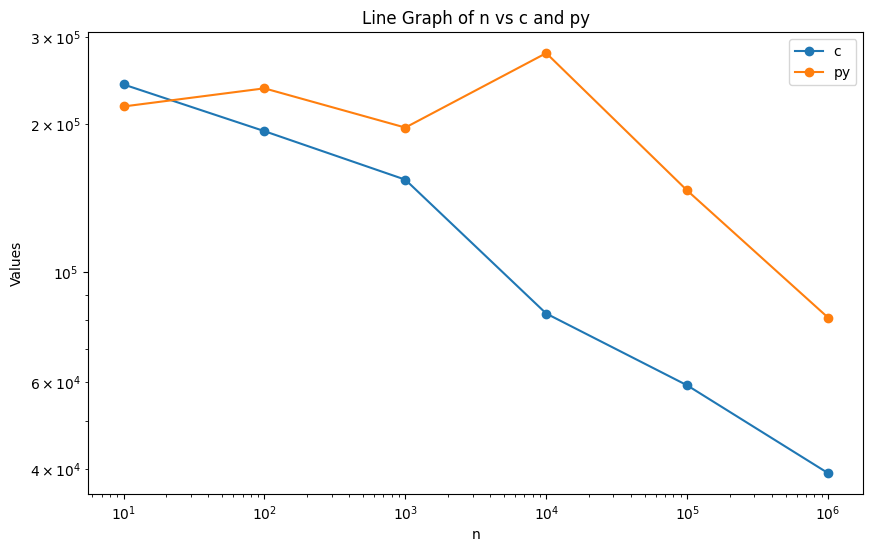

In [23]:
import matplotlib.pyplot as plt

n = [10, 100, 1000, 10000, 100000, 1000000]
# c_total =  [2405188, 19341221, 154208660, 825600987,  5905819087,  39203974489]
# py_total = [2170112, 23618304, 196647680, 2783703296, 14664035840, 81013771776]
c =  [240518, 193412, 154208, 82560,  59058,  39203]
py = [217011, 236183, 196647, 278370, 146640, 81013]

plt.figure(figsize=(10, 6))
plt.plot(n, c, marker='o', label='c')
plt.plot(n, py, marker='o', label='py')

# 軸のラベル
plt.xlabel('n')
plt.ylabel('Values')
plt.title('Line Graph of n vs c and py')

# 軸のスケールを対数に変更
plt.xscale('log')
plt.yscale('log')

# 凡例の表示
plt.legend()

# グラフの表示
plt.show()

|         |       10 |      100 |    1,000 |   10,000 |  100,000 | 1,000,000 |
|---------|---------:|---------:|---------:|---------:|---------:|----------:|
| c       |  240,518 |  193,412 |  154,208 |   82,560 |   59,058 |    39,203 |
| py      |  217,011 |  236,183 |  196,647 |  278,370 |  146,640 |    81,013 |


# 観察結果
- ループ回数が1000まではCもPythonも1threadの実行時間は変わらない。
- ループ回数を1万を超えるとCほうが明らかにPythonより早くなる。かつ、ループ回数1000にくらべて約2倍速くなっている。
- さらに10万、100万と呼び出し回数を増やすとCの性能は改善していく。
- この傾向はPythonにも当てはまっているが、Pythonの場合は10万回の呼び出しから改善の傾向にある

# 考察
- 呼び出しを繰り返すことによってdo_nothing関数がCPUキャッシュに乗るようになり呼び出しの性能が改善されている？
- CよりもPythonのほうが関数呼び出しのオーバーヘッドが大きくCPUキャッシュに乗りづらいのではないか
  